In [1]:
# -*- coding: utf-8 -*-
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
# sns.set_style('whitegrid')

ip = pd.read_excel('中医小儿肺炎数据集_train.xlsx')
ip_test = pd.read_excel('中医小儿肺炎数据集_test.xlsx')

# 第一步：查看数据
ip_valueList = ip.columns.values.tolist()
print(ip_valueList)
print('特征数量：'+str(len(ip.columns.values.tolist())))
print("-"*50 + "查看数据的统计学概况" + "-"*50)
# 身高，体重，需要噪声值处理并进行正则化；
# 低体重，营养不良，贫血，佝偻病，面白，散在斑疹，面色苍白，腹胀，极端症/突然面白，
# 四肢厥冷，额汗不温，虚烦不安，谵语，抽搐，胁下瘀块，口噤，项强，两目上视， 因为全是0，所以可以删去
# 肝正常，因为全是1，所以可以删去
# 体温 以减掉平均值来进行映射到一个较小的数据
# 呼吸进行噪声值处理，
# 血压，呼吸音弱，异常注释.1，进行正则化
# 注意用catboost
pd.set_option('display.max_columns',200) # 防止因大量数据导致数据显示不全
# print(ip.describe())
print("-"*50 + "数据情况" + "-"*50)
print(ip.info())
# print(ip.describe())
print("-"*50 + "中医小儿肺炎数据集_train.xlsx查看缺失值" + "-"*50)
print(ip.isnull().sum().sort_values(ascending=False).head(10)) # 简单查看缺失值概况
print("-"*50 + "中医小儿肺炎数据集_test.xlsx查看缺失值" + "-"*50)
print(ip_test.info())
print(ip_test.isnull().sum().sort_values(ascending=False).head(10))

FileNotFoundError: [Errno 2] No such file or directory: '中医小儿肺炎数据集_train.xlsx'

In [2]:
print("-"*50 + "下面开始对身高,体重正则化处理" + "-"*50)
from sklearn import preprocessing
# 身高，体重，需要噪声值处理并进行正则化；
mms_height_train = np.array(ip["身高"])
mms_height_test = np.array(ip_test["身高"])
# 由于身高，体重，病程缺失值较少，所以直接删掉
ip["身高"][ip["身高"].isnull()] = ip["身高"].dropna().mode().values
ip["体重"][ip["体重"].isnull()] = ip["体重"].dropna().mode().values
ip["病程"][ip["病程"].isnull()] = ip["病程"].dropna().mode().values
ip_test["身高"][ip_test["身高"].isnull()] = ip_test["身高"].dropna().mode().values
ip_test["体重"][ip_test["体重"].isnull()] = ip_test["体重"].dropna().mode().values
print(ip.isnull().sum().sort_values(ascending=False).head(7)) 
# 身高正则化
print("身高scaler：\n")
mms_height_train = np.array(ip["身高"]).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
height_train_minmax = min_max_scaler.fit_transform(mms_height_train)
ip["身高"] = height_train_minmax

mms_height_test = np.array(ip_test["身高"]).reshape(-1,1)
min_max_scaler_test = preprocessing.MinMaxScaler(feature_range=(0,10))
height_test_minmax = min_max_scaler_test.fit_transform(mms_height_test)
ip_test["身高"] = height_test_minmax
print(height_train_minmax)
# 体重正则化
print("体重scaler：\n")
mms_weight_train = np.array(ip["体重"]).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,10))
weight_train_minmax = min_max_scaler.fit_transform(mms_weight_train)
ip["体重"] = weight_train_minmax

mms_weight_test = np.array(ip_test["体重"]).reshape(-1,1)
min_max_scaler_test = preprocessing.MinMaxScaler(feature_range=(0,10))
weight_test_minmax = min_max_scaler_test.fit_transform(mms_weight_test)
ip_test["体重"] = weight_test_minmax
print(weight_train_minmax)
# ip

--------------------------------------------------下面开始对身高,体重正则化处理--------------------------------------------------
异常注释.1    572
血压低压      430
血压高压      430
程度        200
汗/性质      200
降低         50
升高.1       50
dtype: int64
身高scaler：

[[4.26829268]
 [4.26829268]
 [4.26829268]
 ...
 [1.95121951]
 [3.29268293]
 [3.29268293]]
体重scaler：

[[1.16788321]
 [1.16788321]
 [1.16788321]
 ...
 [0.51094891]
 [1.38686131]
 [1.38686131]]


In [3]:
#  填补缺失值，针对含有缺失值属性的 特征重要性分析 并 选择特征
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(ip_train_data_X, ip_train_data_Y, top_n_features):
    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2,4], 'max_depth': [15]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=2, cv=5, verbose=1)
    rf_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01,0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=2, cv=5, verbose=1)
    ada_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(ip_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3,4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=2, cv=5, verbose=1)
    et_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))

    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=2, cv=5, verbose=1)
    gb_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(ip_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))

    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=2, cv=5, verbose=1)
    dt_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))

    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt],
                               ignore_index=True).drop_duplicates()[:top_n_features]

    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et,
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)

    return features_top_n , features_importance

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# 第二步：进行缺失值的处理
# 身高，体重；（经观察没有发现较多噪声值，可忽略噪声值处理）
# 由于身高，体重，病程缺失值较少，所以直接删掉缺失行
ip["身高"][ip["身高"].isnull()] = ip["身高"].dropna().mode().values
ip["体重"][ip["体重"].isnull()] = ip["体重"].dropna().mode().values
ip["病程"][ip["病程"].isnull()] = ip["病程"].dropna().mode().values

ip_test["身高"][ip_test["身高"].isnull()] = ip_test["身高"].dropna().mode().values
ip_test["体重"][ip_test["体重"].isnull()] = ip_test["体重"].dropna().mode().values
print(ip.isnull().sum().sort_values(ascending=False).head(7)) 
print(ip.info())

异常注释.1    572
血压低压      430
血压高压      430
程度        200
汗/性质      200
降低         50
升高.1       50
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Columns: 195 entries, 身高 to 病毒性肺炎
dtypes: float64(31), int64(164)
memory usage: 1.9 MB
None


In [5]:
print("-"*50 + "中医小儿肺炎数据集_train.xlsx查看缺失值" + "-"*50)
print(ip.isnull().sum().sort_values(ascending=False).head(10))

--------------------------------------------------中医小儿肺炎数据集_train.xlsx查看缺失值--------------------------------------------------
异常注释.1    572
血压低压      430
血压高压      430
程度        200
汗/性质      200
降低         50
升高.1       50
水泡          0
散在斑疹        0
热性面容        0
dtype: int64


In [6]:
print("-"*50 + "异常注释.1 缺失值预测填补" + "-"*50)
from sklearn.model_selection import train_test_split

ip_yiChang_df = ip.drop(['血压低压','血压高压','程度',
                         '汗/性质','降低','升高.1'],axis=1)
ip_yiChang_df_test = ip_test.drop(['血压低压','血压高压','程度',
                         '汗/性质','降低','升高.1'],axis=1)

yiChang_df_notnull = ip_yiChang_df.loc[(ip_yiChang_df['异常注释.1'].notnull())]
yiChang_df_isnull = ip_yiChang_df.loc[(ip_yiChang_df['异常注释.1'].isnull())]
# 其实test文件中的异常注释全为null所以，直接预测
# yiChang_df_test_notnull = ip_yiChang_df_test.loc[(ip_yiChang_df_test['异常注释.1'].notnull())]
yiChang_df_test_isnull = ip_yiChang_df_test.loc[(ip_yiChang_df_test['异常注释.1'].isnull())]

ip_x_yiChang = yiChang_df_notnull.drop(["异常注释.1"],axis=1)
ip_y_yiChang = yiChang_df_notnull["异常注释.1"]
ip_train_data_X_yiChang,ip_test_data_X_yiChang, ip_train_data_Y_yiChang, ip_test_data_Y_yiChang=train_test_split(ip_x_yiChang,ip_y_yiChang,test_size=0.3, random_state=10)

feature_to_pick = 60
feature_top_n_yiChang, feature_importance_yiChang = get_top_n_features(ip_train_data_X_yiChang, 
                                                       ip_train_data_Y_yiChang.astype(int),
                                                       feature_to_pick)
ip_train_data_X_yiChang = pd.DataFrame(ip_train_data_X_yiChang[feature_top_n_yiChang])
ip_test_data_X_yiChang = pd.DataFrame(ip_test_data_X_yiChang[feature_top_n_yiChang])
yiChang_df_isnull_x = yiChang_df_isnull.drop(["异常注释.1"],axis=1)
yiChang_df_isnull_x =  pd.DataFrame(yiChang_df_isnull_x[feature_top_n_yiChang])

yiChang_df_isnull_x_test = yiChang_df_test_isnull.drop(["异常注释.1"],axis=1)
yiChang_df_isnull_x_test =  pd.DataFrame(yiChang_df_isnull_x_test[feature_top_n_yiChang])

from sklearn.ensemble import RandomForestClassifier

clf_yiChang = RandomForestClassifier(n_estimators=500,max_depth= 20, min_samples_split=2) 

clf_yiChang.fit(ip_train_data_X_yiChang,ip_train_data_Y_yiChang.astype(int))
from sklearn.model_selection import cross_val_score

scores_yiChang = cross_val_score(clf_yiChang,ip_test_data_X_yiChang,ip_test_data_Y_yiChang.astype(int)) 
print("异常注释.1: ",scores_yiChang.mean())

# 开始预测 
predict_yiCahng = clf_yiChang.predict(yiChang_df_isnull_x)
predict_yiCahng_test = clf_yiChang.predict(yiChang_df_isnull_x_test)

# 填补缺失值
ip.loc[ip['异常注释.1'].isnull(), ['异常注释.1']]= predict_yiCahng
ip_test.loc[ip_test['异常注释.1'].isnull(), ['异常注释.1']]= predict_yiCahng_test

print("-"*50 + "中医小儿肺炎数据集_train.xlsx查看缺失值" + "-"*50)
print(ip.isnull().sum().sort_values(ascending=False).head(10))
print("-"*50 + "中医小儿肺炎数据集_test.xlsx查看缺失值" + "-"*50)
print(ip_test.isnull().sum().sort_values(ascending=False).head(10))


--------------------------------------------------异常注释.1 缺失值预测填补--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.1s finished


Top N Features Best RF Params:{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
43     体温 
1       体重
0       身高
10      病程
45    静息心律
85      升高
44      呼吸
61      片影
90    降低.1
59      水泡
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.5s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.8644400785854617
Top N Features Ada Train Score:0.8388998035363457
Sample 10 Feature from Ada Classifier:
10        病程
43       体温 
0         身高
85        升高
18      痰白粘 
1         体重
75      呼吸音弱
77    也不知道是啥
80      ADV+
76       MP1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.4s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
43     体温 
61      片影
10      病程
0       身高
44      呼吸
1       体重
85      升高
45    静息心律
59      水泡
52     x结果
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  1.2min finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.9960707269155207
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
43     体温 
10      病程
0       身高
1       体重
45    静息心律
75    呼吸音弱
18    痰白粘 
76     MP1
90    降低.1
37      呕吐
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.4s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:0.9921414538310412
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
43     体温 
21      喘憋
45    静息心律
10      病程
85      升高
12      恶寒
1       体重
37      呕吐
75    呼吸音弱
63      纹理
Name: feature, dtype: object
异常注释.1:  0.9330338040222507
--------------------------------------------------中医小儿肺炎数据集_train.xlsx查看缺失值--------------------------------------------------
血压低压     430
血压高压     430
程度       200
汗/性质     200
降低        50
升高.1      50
喘鸣音        0
热性面容       0
面色略灰       0
三凹征.1      0
dtype: int64
--------------------------------------------------中医小儿肺炎数据集_test.xlsx查看缺失值--------------------------------------------------
程度       200
汗/性质     200
血压低压      81
血压高压      81
降低        24
升高.1      24
喘鸣音        0
热性面容       0
面色略灰       0
三凹征.1      0
dtype: int64


In [7]:
print("-"*50 + "血压低压,血压高压预测处理" + "-"*50)
# 血压低压,血压高压均有511个缺失值，所以进行特征间重要程度分析，找出相关特征
# 然后构建相关模型进行预测血压低压,血压高压 
ip_valueList = ip.columns.values.tolist()
# ip['血压低压'] = ip['血压低压'].fillna(ip['血压低压'].mean())
# ip['血压高压'] = ip['血压高压'].fillna(ip['血压高压'].mean())
# ip_test['血压低压'] = ip_test['血压低压'].fillna(ip_test['血压低压'].mean())
# ip_test['血压高压'] = ip_test['血压高压'].fillna(ip_test['血压高压'].mean())
print(ip.isnull().sum().sort_values(ascending=False).head(10))

ip_src = ip
ip_test_src = ip_test

###############RandomForestClassifier#############
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#导入数据
ip_rf_src = ip_src.drop(["程度","汗/性质","降低",
                         "升高.1","血压高压"],axis=1)
ip_test_rf_src = ip_test_src.drop(["程度","汗/性质","降低",
                         "升高.1","血压高压"],axis=1)

ip_rf_src
print(ip_rf_src.isnull().sum().sort_values(ascending=False).head(10))

PressureL_df_notnull = ip_rf_src.loc[(ip_rf_src['血压低压'].notnull())]
PressureL_df_isnull = ip_rf_src.loc[(ip_rf_src['血压低压'].isnull())]
PressureL_df_test_isnull = ip_test_rf_src.loc[(ip_test_rf_src['血压低压'].isnull())]

ip_x_PressureL = PressureL_df_notnull.drop(["血压低压"],axis=1)
ip_y_PressureL = PressureL_df_notnull["血压低压"]
#分割训练集合测试集
X,y=ip_x_PressureL,ip_y_PressureL
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

feature_to_pick_PressureL = 40
feature_top_n_PressureL, feature_importance_PressureL = get_top_n_features(X_train, 
                                                       y_train.astype(int),
                                                       feature_to_pick_PressureL)

X_train = pd.DataFrame(X_train[feature_top_n_PressureL])
X_test = pd.DataFrame(X_test[feature_top_n_PressureL])
PressureL_df_isnull_x = PressureL_df_isnull.drop(["血压低压"],axis=1)
PressureL_df_isnull_x = pd.DataFrame(PressureL_df_isnull_x[feature_top_n_PressureL])

PressureL_df_isnull_x_test = PressureL_df_test_isnull.drop(["血压低压"],axis=1)
PressureL_df_isnull_x_test =  pd.DataFrame(PressureL_df_isnull_x_test[feature_top_n_PressureL])

clf_PressureL = RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_split=2)
clf_PressureL.fit(X_train,y_train.astype(int))
from sklearn.model_selection import cross_val_score
scores_PressureL = cross_val_score(clf_PressureL,X_test,y_test.astype(int))
print("血压低压: ",scores_PressureL.mean())
# 开始预测
predict_PressureL = clf_PressureL.predict(PressureL_df_isnull_x)
predict_PressureL_test = clf_PressureL.predict(PressureL_df_isnull_x_test)
# 填补缺失值
ip.loc[ip['血压低压'].isnull(), ['血压低压']]= predict_PressureL
ip_test.loc[ip_test['血压低压'].isnull(), ['血压低压']]= predict_PressureL_test

print("-"*50 + "中医小儿肺炎数据集_train.xlsx查看缺失值" + "-"*50)
print(ip.isnull().sum().sort_values(ascending=False).head(10))
print("-"*50 + "中医小儿肺炎数据集_test.xlsx查看缺失值" + "-"*50)
print(ip_test.isnull().sum().sort_values(ascending=False).head(10))


--------------------------------------------------血压低压,血压高压预测处理--------------------------------------------------
血压低压     430
血压高压     430
程度       200
汗/性质     200
降低        50
升高.1      50
喘鸣音        0
热性面容       0
面色略灰       0
三凹征.1      0
dtype: int64
血压低压     430
病毒性肺炎      0
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
纹理         0
痰鸣音        0
片影         0
dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.7s finished


Top N Features Best RF Params:{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
1          体重
10         病程
0          身高
43        体温 
101    异常注释.1
45       静息心律
85         升高
61         片影
44         呼吸
76        MP1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.1s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.5675287356321839
Top N Features Ada Train Score:0.5919540229885057
Sample 10 Feature from Ada Classifier:
1         体重
43       体温 
10        病程
187    支原体肺炎
66      热性面容
65      面色略灰
33        口渴
20        气促
45      静息心律
30        乏力
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.5s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:0.9985632183908046
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
10         病程
1          体重
0          身高
43        体温 
101    异常注释.1
61         片影
84     是否正常.2
27        无汗 
93     是否正常.6
56       扁桃体大
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   48.0s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.9956896551724138
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
0          身高
90       降低.1
65       面色略灰
66       热性面容
1          体重
85         升高
101    异常注释.1
43        体温 
95       尿pro
37         呕吐
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.4s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:0.9956896551724138
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
45    静息心律
85      升高
43     体温 
37      呕吐
1       体重
0       身高
56    扁桃体大
90    降低.1
13      恶风
10      病程
Name: feature, dtype: object
血压低压:  0.8193134822167081
--------------------------------------------------中医小儿肺炎数据集_train.xlsx查看缺失值--------------------------------------------------
血压高压     430
程度       200
汗/性质     200
降低        50
升高.1      50
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
dtype: int64
--------------------------------------------------中医小儿肺炎数据集_test.xlsx查看缺失值--------------------------------------------------
程度       200
汗/性质     200
血压高压      81
降低        24
升高.1      24
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
dtype: int64


In [8]:
ip_rf_src = ip_src.drop(["程度","汗/性质","降低",
                         "升高.1","血压低压"],axis=1)
ip_test_rf_src = ip_test_src.drop(["程度","汗/性质","降低",
                         "升高.1","血压低压"],axis=1)

ip_rf_src
print(ip_rf_src.isnull().sum().sort_values(ascending=False).head(10))

PressureH_df_notnull = ip_rf_src.loc[(ip_rf_src['血压高压'].notnull())]
PressureH_df_isnull = ip_rf_src.loc[(ip_rf_src['血压高压'].isnull())]
PressureH_df_test_isnull = ip_test_rf_src.loc[(ip_test_rf_src['血压高压'].isnull())]

ip_x_PressureH = PressureH_df_notnull.drop(["血压高压"],axis=1)
ip_y_PressureH = PressureH_df_notnull["血压高压"]
#分割训练集合测试集
X,y=ip_x_PressureH,ip_y_PressureH
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

feature_to_pick_PressureH = 40
feature_top_n_PressureH, feature_importance_PressureH = get_top_n_features(X_train, 
                                                       y_train.astype(int),
                                                       feature_to_pick_PressureH)

X_train = pd.DataFrame(X_train[feature_top_n_PressureH])
X_test = pd.DataFrame(X_test[feature_top_n_PressureH])
PressureH_df_isnull_x = PressureH_df_isnull.drop(["血压高压"],axis=1)
PressureH_df_isnull_x = pd.DataFrame(PressureH_df_isnull_x[feature_top_n_PressureH])

PressureH_df_isnull_x_test = PressureH_df_test_isnull.drop(["血压高压"],axis=1)
PressureH_df_isnull_x_test =  pd.DataFrame(PressureH_df_isnull_x_test[feature_top_n_PressureH])

clf_PressureH = RandomForestClassifier(n_estimators=500,max_depth=20,min_samples_split=2)
clf_PressureH.fit(X_train,y_train.astype(int))
from sklearn.model_selection import cross_val_score
scores_PressureH = cross_val_score(clf_PressureH,X_test,y_test.astype(int))
print("血压高压: ",scores_PressureH.mean())
# 开始预测
predict_PressureH = clf_PressureH.predict(PressureH_df_isnull_x)
predict_PressureH_test = clf_PressureH.predict(PressureH_df_isnull_x_test)
# 填补缺失值
ip.loc[ip['血压高压'].isnull(), ['血压高压']]= predict_PressureH
ip_test.loc[ip_test['血压高压'].isnull(), ['血压高压']]= predict_PressureH_test

print("-"*50 + "中医小儿肺炎数据集_train.xlsx查看缺失值" + "-"*50)
print(ip.isnull().sum().sort_values(ascending=False).head(10))
print("-"*50 + "中医小儿肺炎数据集_test.xlsx查看缺失值" + "-"*50)
print(ip_test.isnull().sum().sort_values(ascending=False).head(10))


血压高压     430
病毒性肺炎      0
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
纹理         0
痰鸣音        0
片影         0
dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    6.0s finished


Top N Features Best RF Params:{'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
0          身高
1          体重
101    异常注释.1
45       静息心律
43        体温 
10         病程
44         呼吸
85         升高
90       降低.1
61         片影
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    8.0s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.5977011494252874
Top N Features Ada Train Score:0.5790229885057471
Sample 10 Feature from Ada Classifier:
43        体温 
10         病程
0          身高
1          体重
85         升高
101    异常注释.1
77     也不知道是啥
41       腹胀.1
184      风寒闭肺
54     是否正常.1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.2s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:0.9985632183908046
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
0          身高
101    异常注释.1
1          体重
45       静息心律
43        体温 
10         病程
76        MP1
85         升高
44         呼吸
93     是否正常.6
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   47.5s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:0.9985632183908046
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
101    异常注释.1
0          身高
85         升高
44         呼吸
1          体重
90       降低.1
10         病程
43        体温 
86         下降
45       静息心律
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.3s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:1.0
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
0          身高
45       静息心律
101    异常注释.1
59         水泡
42         尿赤
90       降低.1
85         升高
52        x结果
77     也不知道是啥
43        体温 
Name: feature, dtype: object
血压高压:  0.8041666666666667
--------------------------------------------------中医小儿肺炎数据集_train.xlsx查看缺失值--------------------------------------------------
程度       200
汗/性质     200
降低        50
升高.1      50
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
纹理         0
dtype: int64
--------------------------------------------------中医小儿肺炎数据集_test.xlsx查看缺失值--------------------------------------------------
程度       200
汗/性质     200
降低        24
升高.1      24
喘鸣音        0
散在斑疹       0
热性面容       0
面色略灰       0
三凹征.1      0
纹理         0
dtype: int64


In [9]:
ip['升高.1'] = ip['升高.1'].fillna(ip['升高.1'].mean())
ip['降低'] = ip['降低'].fillna(ip['降低'].mean())
ip_test['升高.1'] = ip_test['升高.1'].fillna(ip_test['升高.1'].mean())
ip_test['降低'] = ip_test['降低'].fillna(ip_test['降低'].mean())

ip['程度'] = ip['程度'].fillna(ip['程度'].mean())
ip['汗/性质'] = ip['汗/性质'].fillna(ip['汗/性质'].mean())

ip_test['程度'] = ip_test['程度'].fillna(ip['程度'].mean())
ip_test['汗/性质'] = ip_test['汗/性质'].fillna(ip['汗/性质'].mean())
print("ip\n",ip.isnull().sum().sort_values(ascending=False).head(10)) # 简单查看缺失值概况
print("ip_test\n",ip_test.isnull().sum().sort_values(ascending=False).head(10)) # 简单查看缺失值概况


ip
 病毒性肺炎    0
头正常      0
面色苍白     0
散在斑疹     0
热性面容     0
面色略灰     0
三凹征.1    0
纹理       0
痰鸣音      0
片影       0
dtype: int64
ip_test
 病毒性肺炎    0
头正常      0
面色苍白     0
散在斑疹     0
热性面容     0
面色略灰     0
三凹征.1    0
纹理       0
痰鸣音      0
片影       0
dtype: int64


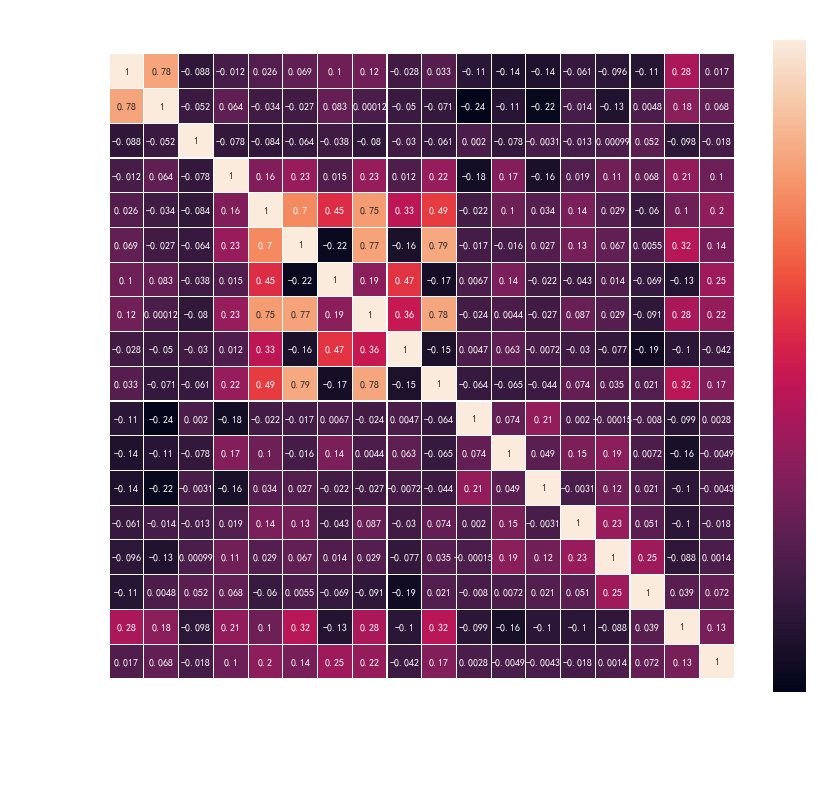

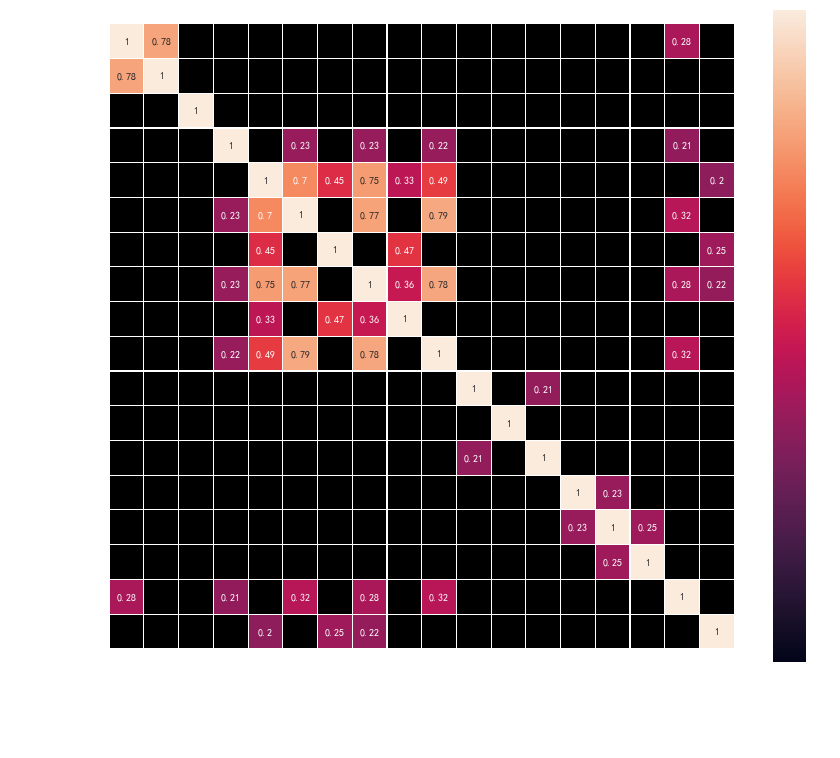

In [10]:
# 特征间相关性分析
# 挑选一些主要的特征，生成特征之间的关联图，查看特征与特征之间的相关性：
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
Correlation = pd.DataFrame(ip[
    [u'身高', u'体重',u'也不知道是啥',u'是否正常.2',u'是否正常.3',u'升高.1', u'降低', u'是否正常.4', u'升高.2', u'降低.1',
     u'是否正常.5',  u'是否正常.6', u'是否正常.7',u'尿pro',u'是否正常.8', 
     u'是否正常.9', u'是否正常.10',u'西医诊断/支气管肺炎']])


# colormap = plt.cm.viridis
cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
# sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,
#             vmax=1.0, square=True, cmap=colormap,
#             linecolor='white', annot=True)
# plt.show()
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,
            vmax=1.0, square=True,
            linecolor='white', annot=True)
plt.show()

plt.figure(figsize=(14,12))
sns.heatmap(Correlation.astype(float).corr(),linewidths=0.1,
            vmax=1.0, square=True,
            linecolor='white', annot=True,
            mask=Correlation.astype(float).corr()<0.2)

plt.show()

In [11]:
# 将肺炎证型搞成一个特征
# 准备构建多分类模型的数据集
ip_multiClassification = ip
ip_test_multiClassification = ip_test
ip_multiClassification.shape
print("ip_multiClassification 的缺失值查看：")
print(ip_multiClassification.isnull().sum().sort_values(ascending=False).head(10))
print("ip_test_multiClassification 的缺失值查看：")
print(ip_test_multiClassification.isnull().sum().sort_values(ascending=False).head(10))

ip_valueList = ip_multiClassification.columns.values.tolist()
print(ip_valueList)
print("-"*50+"类型转换前"+"-"*50)
print(ip_multiClassification['西医诊断/支气管肺炎'].dtypes)
print(ip_multiClassification['细菌性肺炎'].dtypes)
print(ip_multiClassification['支原体肺炎'].dtypes)
print(ip_multiClassification['病毒性肺炎'].dtypes)
ip_multiClassification['西医诊断/支气管肺炎'] = ip_multiClassification['西医诊断/支气管肺炎'].astype(str)
ip_multiClassification['细菌性肺炎'] = ip_multiClassification['细菌性肺炎'].astype(str)
ip_multiClassification['支原体肺炎'] = ip_multiClassification['支原体肺炎'].astype(str)
ip_multiClassification['病毒性肺炎'] = ip_multiClassification['病毒性肺炎'].astype(str)

ip_test_multiClassification['西医诊断/支气管肺炎'] = ip_test_multiClassification['西医诊断/支气管肺炎'].astype(str)
ip_test_multiClassification['细菌性肺炎'] = ip_test_multiClassification['细菌性肺炎'].astype(str)
ip_test_multiClassification['支原体肺炎'] = ip_test_multiClassification['支原体肺炎'].astype(str)
ip_test_multiClassification['病毒性肺炎'] = ip_test_multiClassification['病毒性肺炎'].astype(str)


print("-"*50+"类型转换后"+"-"*50)
print(ip_multiClassification['西医诊断/支气管肺炎'].dtypes)
print(ip_multiClassification['细菌性肺炎'].dtypes)
print(ip_multiClassification['支原体肺炎'].dtypes)
print(ip_multiClassification['病毒性肺炎'].dtypes)

print("-"*50+"开始合并证型"+"-"*50)
ip_multiClassification["证型"] = ip_multiClassification['西医诊断/支气管肺炎']+ip_multiClassification['细菌性肺炎']+ip_multiClassification['支原体肺炎']+ip_multiClassification['病毒性肺炎']
ip_Disease_dummies = pd.get_dummies(ip_multiClassification["证型"])

ip_test_multiClassification["证型"] = ip_test_multiClassification['西医诊断/支气管肺炎']+ip_test_multiClassification['细菌性肺炎']+ip_test_multiClassification['支原体肺炎']+ip_test_multiClassification['病毒性肺炎']
ip_test_Disease_dummies = pd.get_dummies(ip_test_multiClassification["证型"])

# 合并后的特征 0000  0001  0010  0011  0100  0110  1010  1100
print("-"*100)
# 取证型的dummies值（one-hot）
print(ip_Disease_dummies)
ip_multiClassification = ip_multiClassification.join(ip_Disease_dummies)
ip_test_multiClassification = ip_test_multiClassification.join(ip_test_Disease_dummies)
# 将证型factorize化
print(ip_multiClassification["证型"])
disease_factorize = pd.factorize(ip_multiClassification["证型"])
test_disease_factorize = pd.factorize(ip_test_multiClassification["证型"])
print("-"*50+"factorize化的证型"+"-"*50)
ip_multiClassification["证型"] = disease_factorize[0]
ip_test_multiClassification["证型"] = test_disease_factorize[0]
print(disease_factorize)
# import pandas as pd
 
# pd.set_option('display.max_rows',1300)   # 具体的行数或列数可自行设置
# # pd.set_option('display.max_columns',1000)

print(ip_multiClassification[["证型"]])
ip_multiClassification = ip_multiClassification.drop(['西医诊断/支气管肺炎','细菌性肺炎','支原体肺炎','病毒性肺炎'],axis=1)
ip_test_multiClassification = ip_test_multiClassification.drop(['西医诊断/支气管肺炎','细菌性肺炎','支原体肺炎','病毒性肺炎'],axis=1)

ip_valueList = ip_multiClassification.columns.values.tolist()
print(ip_valueList)
print()
ip_test_valueList = ip_test_multiClassification.columns.values.tolist()
print(ip_test_valueList)


ip_multiClassification 的缺失值查看：
病毒性肺炎    0
头正常      0
面色苍白     0
散在斑疹     0
热性面容     0
面色略灰     0
三凹征.1    0
纹理       0
痰鸣音      0
片影       0
dtype: int64
ip_test_multiClassification 的缺失值查看：
病毒性肺炎    0
头正常      0
面色苍白     0
散在斑疹     0
热性面容     0
面色略灰     0
三凹征.1    0
纹理       0
痰鸣音      0
片影       0
dtype: int64
['身高', '体重', '顺产', '早产', '低体重', '剖腹产', '营养不良', '贫血', '佝偻病', '呼吸病', '病程', '发热', '恶寒', '恶风', '声咳', '阵咳', '频咳', '痰白稀', '痰白粘 ', '痰黄稠', '气促', '喘憋', '鼻翼煽动', '口周发绀 ', '三凹征', '面白', '面红', '无汗 ', '自汗', '盗汗', '乏力', '胸闷', '胸痛', '口渴', '烦躁', '嗜睡', '胃纳差', '呕吐', '便溏', '便秘', '腹胀', '腹胀.1', '尿赤', '体温 ', '呼吸', '血压高压', '血压低压', '静息心律', '头正常', '心正常', '肝正常', '皮肤正常 ', '四肢正常', '其它正常', 'x结果', '是否正常', '是否正常.1', '咽充血', '扁桃体大', '双肺呼吸音粗', '喘鸣音', '水泡', '支气管肺炎', '片影', '痰鸣音', '纹理', '三凹征.1', '面色略灰', '热性面容', '散在斑疹', '面色苍白', '罗音', '荨麻疹', '发绀', '鼻涕', '鼻煽', '干鸣', '呼吸音弱', 'MP1', '也不知道是啥', 'MP+', 'MP-IgM+', 'ADV+', 'IV+', 'COXB（+）', ' EBV(+)', '是否正常.2', '升高', '下降', '是否正常.3', '升高.1', '降低', '是否正常.4', '升高.2', '降低.1', '是否正

<function matplotlib.pyplot.show(*args, **kw)>

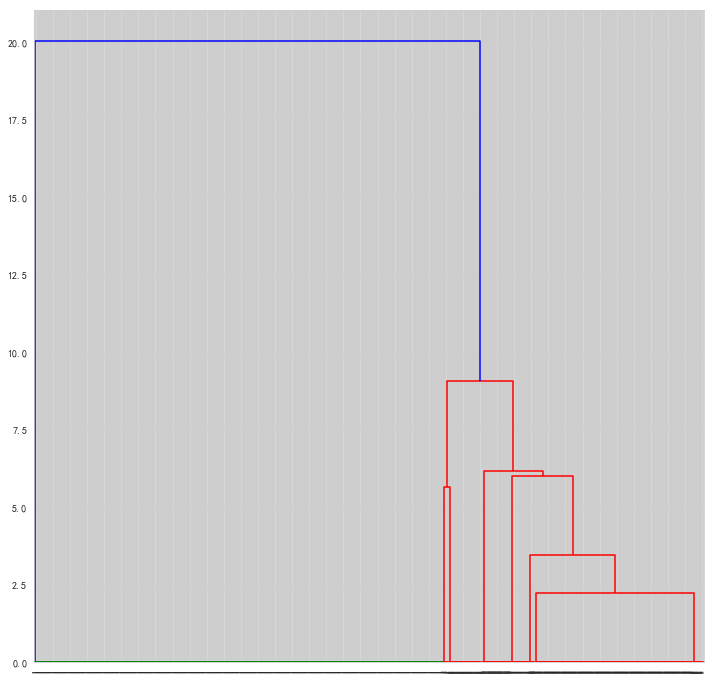

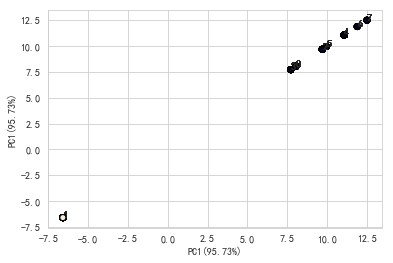

<Figure size 1440x1440 with 0 Axes>

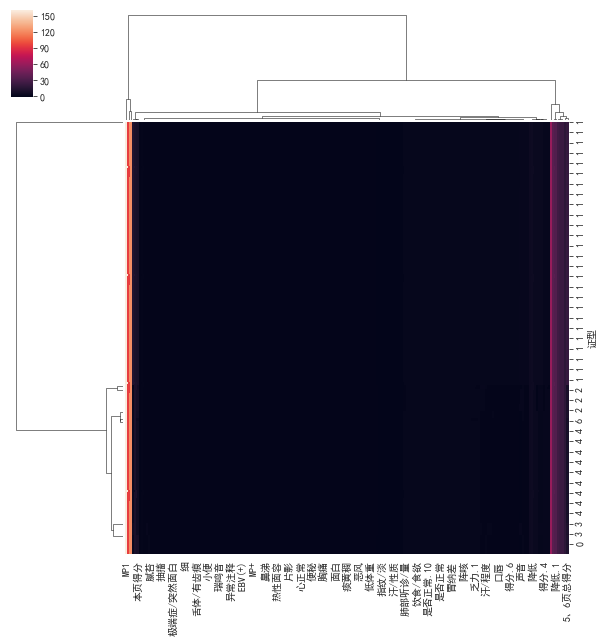

In [12]:
import seaborn as sns  #用于绘制热图的工具包
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
from sklearn import decomposition as skldec #用于主成分分析降维的包
plt.style.use('dark_background')
sns.set_style('whitegrid')
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

variables=ip_multiClassification.columns.values.tolist()
# print(variables)
variables.remove('证型')
variables.remove('0000')
variables.remove('0010')
variables.remove('0011')
variables.remove('0001')
variables.remove('0100')
variables.remove('1010')
variables.remove('1100')
variables.remove('0110')

labels=ip_multiClassification["证型"]
#层次聚类树
X=ip_multiClassification.drop(['证型', '0000', '0001', '0010', '0011',
                               '0100', '0110', '1010', '1100'],axis=1)
fig =plt.figure(figsize=(12,12))
df = pd.DataFrame(X,columns=variables,index=labels)
Z = hierarchy.linkage(df, method ='complete',metric='euclidean')
hierarchy.dendrogram(Z,labels = df.index)

label = cluster.hierarchy.cut_tree(Z,height=17.5)
label = label.reshape(label.size,)

#根据两个最大的主成分进行绘图
pca = skldec.PCA(n_components = 0.95)    #选择方差95%的占比
pca.fit(df)   #主城分析时每一行是一个输入数据
result = pca.transform(df)  #计算结果
# print(result)
plt.figure()  #新建一张图进行绘制
plt.scatter(result[:, 0], 
            result[:, 0], 
            c=label, 
            edgecolor='k') #绘制两个主成分组成坐标的散点图
for i in range(result[:,0].size):
    plt.text(result[i,0],result[i,0],df.index[i])     #在每个点边上绘制数据名称
x_label = 'PC1(%s%%)' % round((pca.explained_variance_ratio_[0]*100.0),2)   #x轴标签字符串
y_label = 'PC1(%s%%)' % round((pca.explained_variance_ratio_[0]*100.0),2)   #y轴标签字符串
plt.xlabel(x_label)    #绘制x轴标签
plt.ylabel(y_label)    #绘制y轴标签
plt.show

fig =plt.figure(figsize=(20,20))
sns.clustermap(df,method ='ward',metric='euclidean')
plt.show


In [13]:
# 我们知道 聚类有：层次聚类，划分聚类，密度聚类
# 进行层次聚类对证型对应的症状进行挖掘(Hierarchical clustering)
# 无监督聚类学习-层次聚类(hierarchical clustering)，
# 自下向上的凝聚和自顶向下的分裂两种方法。

plt.style.use('dark_background')
sns.set_style('whitegrid')

#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

variables=ip_multiClassification.columns.values.tolist()
# print(variables)
variables.remove('证型')
variables.remove('0000')
variables.remove('0010')
variables.remove('0011')
variables.remove('0001')
variables.remove('0100')
variables.remove('1010')
variables.remove('1100')
variables.remove('0110')

labels=ip_multiClassification["证型"]
#层次聚类树
X=ip_multiClassification.drop(['证型', '0000', '0001', '0010', '0011',
                               '0100', '0110', '1010', '1100'],axis=1)
df = pd.DataFrame(X,columns=variables,index=labels)

#凝聚层次聚类，应用对层次聚类树剪枝
ac=AgglomerativeClustering(n_clusters=8,affinity='euclidean',linkage='complete')
labels = ac.fit_predict(X.T)
 
print ('cluster labels:%s'%labels)
print(labels.size)

cluster labels:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 7 3 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
191


In [14]:
from sklearn.model_selection import train_test_split
# ip_multiClassification
ip_multiClassification_x = ip_multiClassification.drop(["证型"],axis=1)
ip_multiClassification_y = ip_multiClassification["证型"]
ip_multiClassification_train_data_X,ip_multiClassification_test_data_X, ip_multiClassification_train_data_Y, ip_multiClassification_test_data_Y=train_test_split(ip_multiClassification_x,ip_multiClassification_y,test_size=0.2, random_state=10)
ip_test_multiClassification_x = ip_test_multiClassification.drop(["证型"],axis=1)
ip_test_multiClassification_y = ip_test_multiClassification["证型"]


ip_x_1 = ip.drop(["西医诊断/支气管肺炎"],axis=1)
ip_y_1 = ip["西医诊断/支气管肺炎"]
ip_train_data_X_1,ip_test_data_X_1, ip_train_data_Y_1, ip_test_data_Y_1=train_test_split(ip_x_1,ip_y_1,test_size=0.2, random_state=10)
ip_test_x_1 = ip_test.drop(["西医诊断/支气管肺炎"],axis=1)
ip_test_y_1 = ip_test["西医诊断/支气管肺炎"]

ip_x_2 = ip.drop(["细菌性肺炎"],axis=1)
ip_y_2 = ip["细菌性肺炎"]
ip_train_data_X_2,ip_test_data_X_2, ip_train_data_Y_2, ip_test_data_Y_2=train_test_split(ip_x_2,ip_y_2,test_size=0.2, random_state=10)
ip_test_x_2 = ip_test.drop(["细菌性肺炎"],axis=1)
ip_test_y_2 = ip_test["细菌性肺炎"]

ip_x_3 = ip.drop(["支原体肺炎"],axis=1)
ip_y_3 = ip["支原体肺炎"]
ip_train_data_X_3,ip_test_data_X_3, ip_train_data_Y_3, ip_test_data_Y_3=train_test_split(ip_x_3,ip_y_3,test_size=0.2, random_state=10)
ip_test_x_3 = ip_test.drop(["支原体肺炎"],axis=1)
ip_test_y_3 = ip_test["支原体肺炎"]

ip_x_4 = ip.drop(["病毒性肺炎"],axis=1)
ip_y_4 = ip["病毒性肺炎"]
ip_train_data_X_4,ip_test_data_X_4, ip_train_data_Y_4, ip_test_data_Y_4=train_test_split(ip_x_4,ip_y_4,test_size=0.2, random_state=10)
ip_test_x_4 = ip_test.drop(["病毒性肺炎"],axis=1)
ip_test_y_4 = ip_test["病毒性肺炎"]



In [15]:
# 使用Apriori进行证型与症状之间关联规则的挖掘 
from numpy import *

def loadDataSet():
    return ip_multiClassification_x.values
def createC1(dataSet):
    C1=[]
    for transaction in dataSet:
        for item in transaction:
            if not [item] in C1:
                C1.append([item])
    C1.sort()
    return list(map(frozenset,C1))
def scanD(D,Ck,minSupport):
    #在这一行后加了代码
    M=list(D)
    numItems=float(len(M))#因为M是list对象,可以用len()
    print(list(M))#这一行可以验证M可以用多次啦，哈哈哈
    ssCnt={}
    for tid in M:#后面的D都要变成M，没办法得用多次就只能M了
        for can in Ck:
            if can.issubset(tid):
                if not can in ssCnt:
                    ssCnt[can]=1
                else:ssCnt[can]+=1
    #print(list(D))
    #numItems=float(len(D))
    print(numItems)
    retList=[]
    supportData={}
    for key in ssCnt:
        support=ssCnt[key]/numItems
        if support>=minSupport:
            retList.insert(0,key)
        supportData[key]=support
    return retList,supportData

# if __name__ == '__main__':
#     # 导入数据集
#     myDat = loadDataSet()
#     # 构建第一个候选项集列表C1
#     C1 = createC1( myDat )
    
#     # 构建集合表示的数据集 D
#     D = map( set, myDat )
#     # 选择出支持度不小于0.5 的项集作为频繁项集
#     L, suppData = scanD( D, C1, 0.5 )
   
#     print ("频繁项集L：", L)
#     print ("所有候选项集的支持度信息：", suppData)
    
    
# Aprior算法
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()
            if L1 == L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D = map( set, dataSet )
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

# if __name__ == '__main__':
#     # 导入数据集
#     myDat = loadDataSet()    
#     # 选择频繁项集
#     L, suppData = apriori( myDat, 0.7 )
#     print (u"频繁项集L：", L)
#     print (u"所有候选项集的支持度信息：", suppData)
    
# 规则生成与评价   
def calcConf( freqSet, H, supportData, brl, minConf=0.7 ):
    '''
    计算规则的可信度，返回满足最小可信度的规则。
    
    freqSet(frozenset):频繁项集
    H(frozenset):频繁项集中所有的元素
    supportData(dic):频繁项集中所有元素的支持度
    brl(tuple):满足可信度条件的关联规则
    minConf(float):最小可信度
    '''
    prunedH = []
    for conseq in H:
        conf = supportData[ freqSet ] / supportData[ freqSet - conseq ]
        if conf >= minConf:
            print (freqSet - conseq, '-->', conseq, 'conf:', conf)
            brl.append( ( freqSet - conseq, conseq, conf ) )
            prunedH.append( conseq )
    return prunedH

def rulesFromConseq( freqSet, H, supportData, brl, minConf=0.7 ):
    '''
    对频繁项集中元素超过2的项集进行合并。
    
    freqSet(frozenset):频繁项集
    H(frozenset):频繁项集中的所有元素，即可以出现在规则右部的元素
    supportData(dict):所有项集的支持度信息
    brl(tuple):生成的规则
    
    '''
    m = len( H[ 0 ] )
    
    # 查看频繁项集是否大到移除大小为 m　的子集
    if len( freqSet ) > m + 1:
        Hmp1 = aprioriGen( H, m + 1 )
        Hmp1 = calcConf( freqSet, Hmp1, supportData, brl, minConf )
        
        # 如果不止一条规则满足要求，进一步递归合并
        if len( Hmp1 ) > 1:
            rulesFromConseq( freqSet, Hmp1, supportData, brl, minConf )

def generateRules( L, supportData, minConf=0.7 ):
    '''
    根据频繁项集和最小可信度生成规则。
    
    L(list):存储频繁项集
    supportData(dict):存储着所有项集（不仅仅是频繁项集）的支持度
    minConf(float):最小可信度
    '''
    bigRuleList = []
    for i in range( 1, len( L ) ):
        for freqSet in L[ i ]:
            # 对于每一个频繁项集的集合freqSet
            H1 = [ frozenset( [ item ] ) for item in freqSet ]
            
            # 如果频繁项集中的元素个数大于2，需要进一步合并
            if i > 1:
                rulesFromConseq( freqSet, H1, supportData, bigRuleList, minConf )
            else:
                calcConf( freqSet, H1, supportData, bigRuleList, minConf )
    return bigRuleList

if __name__ == '__main__':
    # 导入数据集
    myDat = loadDataSet()    
    # 选择频繁项集
    L, suppData = apriori( myDat, 0.5)
    print("L\n",L)
    rules = generateRules( L, suppData, minConf=0.7)
    print ('rules:\n', rules)

[{0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 4.0, 10.2, 8.0, 12.0, 18.21384, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 9.0, 10.2, 13.0, 18.21384, 22.0, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 7.0, 10.2, 10.0, 18.21384, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 6.0, 10.2, 5.0, 11.0, 18.21384, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 4.0, 10.2, 5.0, 9.0, 18.21384, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.167883211678832, 1.0, 3.0, 4.268292682926829, 0.4, 0.2, 4.8956, 2.0, 4.0, 10.2, 6.0, 10.0, 18.21384, 24.0, 26.0, 160.0, 33.3, 36.5, 60.0, 95.0, 122.0, -1.0}, {0.0, 1.

In [16]:
# 特征选择
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

def get_top_n_features(ip_train_data_X, ip_train_data_Y, top_n_features):
    # random forest
    rf_est = RandomForestClassifier(random_state=0)
    rf_param_grid = {'n_estimators': [500], 'min_samples_split': [2, 3], 'max_depth': [20]}
    rf_grid = model_selection.GridSearchCV(rf_est, rf_param_grid, n_jobs=1, cv=5, verbose=1)
    rf_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best RF Params:' + str(rf_grid.best_params_))
    print('Top N Features Best RF Score:' + str(rf_grid.best_score_))
    print('Top N Features RF Train Score:' + str(rf_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_rf = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': rf_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_rf = feature_imp_sorted_rf.head(top_n_features)['feature']
    print('Sample 10 Features from RF Classifier')
    print(str(features_top_n_rf[:10]))

    # AdaBoost
    ada_est =AdaBoostClassifier(random_state=0)
    ada_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1]}
    ada_grid = model_selection.GridSearchCV(ada_est, ada_param_grid, n_jobs=1, cv=5, verbose=1)
    ada_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best Ada Params:' + str(ada_grid.best_params_))
    print('Top N Features Best Ada Score:' + str(ada_grid.best_score_))
    print('Top N Features Ada Train Score:' + str(ada_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_ada = pd.DataFrame({'feature': list(ip_train_data_X),
                                           'importance': ada_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_ada = feature_imp_sorted_ada.head(top_n_features)['feature']
    print('Sample 10 Feature from Ada Classifier:')
    print(str(features_top_n_ada[:10]))

    # ExtraTree
    et_est = ExtraTreesClassifier(random_state=0)
    et_param_grid = {'n_estimators': [500], 'min_samples_split': [3, 4], 'max_depth': [20]}
    et_grid = model_selection.GridSearchCV(et_est, et_param_grid, n_jobs=1, cv=5, verbose=1)
    et_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best ET Params:' + str(et_grid.best_params_))
    print('Top N Features Best ET Score:' + str(et_grid.best_score_))
    print('Top N Features ET Train Score:' + str(et_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_et = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': et_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_et = feature_imp_sorted_et.head(top_n_features)['feature']
    print('Sample 10 Features from ET Classifier:')
    print(str(features_top_n_et[:10]))

    # GradientBoosting
    gb_est =GradientBoostingClassifier(random_state=0)
    gb_param_grid = {'n_estimators': [500], 'learning_rate': [0.01, 0.1], 'max_depth': [20]}
    gb_grid = model_selection.GridSearchCV(gb_est, gb_param_grid, n_jobs=1, cv=5, verbose=1)
    gb_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best GB Params:' + str(gb_grid.best_params_))
    print('Top N Features Best GB Score:' + str(gb_grid.best_score_))
    print('Top N Features GB Train Score:' + str(gb_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_gb = pd.DataFrame({'feature': list(ip_train_data_X),
                                           'importance': gb_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_gb = feature_imp_sorted_gb.head(top_n_features)['feature']
    print('Sample 10 Feature from GB Classifier:')
    print(str(features_top_n_gb[:10]))

    # DecisionTree
    dt_est = DecisionTreeClassifier(random_state=0)
    dt_param_grid = {'min_samples_split': [2, 4], 'max_depth': [20]}
    dt_grid = model_selection.GridSearchCV(dt_est, dt_param_grid, n_jobs=1, cv=5, verbose=1)
    dt_grid.fit(ip_train_data_X, ip_train_data_Y)
    print('Top N Features Best DT Params:' + str(dt_grid.best_params_))
    print('Top N Features Best DT Score:' + str(dt_grid.best_score_))
    print('Top N Features DT Train Score:' + str(dt_grid.score(ip_train_data_X, ip_train_data_Y)))
    feature_imp_sorted_dt = pd.DataFrame({'feature': list(ip_train_data_X),
                                          'importance': dt_grid.best_estimator_.feature_importances_}).sort_values('importance', ascending=False)
    features_top_n_dt = feature_imp_sorted_dt.head(top_n_features)['feature']
    print('Sample 10 Features from DT Classifier:')
    print(str(features_top_n_dt[:10]))

    # merge the three models
    features_top_n = pd.concat([features_top_n_rf, features_top_n_ada, features_top_n_et, features_top_n_gb, features_top_n_dt],
                               ignore_index=True).drop_duplicates()[:top_n_features]

    features_importance = pd.concat([feature_imp_sorted_rf, feature_imp_sorted_ada, feature_imp_sorted_et,
                                   feature_imp_sorted_gb, feature_imp_sorted_dt],ignore_index=True)

    return features_top_n , features_importance

In [17]:
# ip_multiClassification
feature_to_pick_multi = 130
ip_multiClassification_train_data_X = ip_multiClassification_train_data_X.drop(['0000', '0001', '0010', '0011', '0100', '0110', '1010', '1100'],axis=1)
ip_multiClassification_test_data_X = ip_multiClassification_test_data_X.drop(['0000', '0001', '0010', '0011', '0100', '0110', '1010', '1100'],axis=1)
ip_test_multiClassification_x = ip_test_multiClassification_x.drop(['0000', '0010', '0100', '1000', '1010'],axis=1)

print("-"*50 + "多分类：证型" + "-"*50)
feature_top_n_multi, feature_importance_multi = get_top_n_features(ip_multiClassification_train_data_X, 
                                                       ip_multiClassification_train_data_Y,
                                                       feature_to_pick_multi)
ip_multiClassification_train_data_X = pd.DataFrame(ip_multiClassification_train_data_X[feature_top_n_multi])
ip_multiClassification_test_data_X = pd.DataFrame(ip_multiClassification_test_data_X[feature_top_n_multi])
ip_test_multiClassification_x = pd.DataFrame(ip_test_multiClassification_x[feature_top_n_multi])


--------------------------------------------------多分类：证型--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.4s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
56     是否正常.1
78        MP1
10         病程
105    异常注释.1
1          体重
0          身高
43        体温 
94       降低.1
45       血压高压
47       静息心律
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:0.7163461538461539
Top N Features Ada Train Score:0.7173076923076923
Sample 10 Feature from Ada Classifier:
24       三凹征
10        病程
94      降低.1
56    是否正常.1
91        降低
82      ADV+
23     口周发绀 
9        呼吸病
79    也不知道是啥
88        下降
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
56     是否正常.1
78        MP1
9         呼吸病
54        x结果
1          体重
10         病程
61         水泡
45       血压高压
63         片影
105    异常注释.1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:1.0
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
56      是否正常.1
91          降低
88          下降
68        热性面容
23       口周发绀 
94        降低.1
1           体重
84     COXB（+）
105     异常注释.1
104    是否正常.10
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:0.9980769230769231
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
56      是否正常.1
15          阵咳
104    是否正常.10
105     异常注释.1
79      也不知道是啥
94        降低.1
83         IV+
0           身高
91          降低
23       口周发绀 
Name: feature, dtype: object


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [18]:
feature_to_pick = 130
print("-"*50 + "西医诊断/支气管肺炎" + "-"*50)
feature_top_n_1, feature_importance_1 = get_top_n_features(ip_train_data_X_1, 
                                                       ip_train_data_Y_1,
                                                       feature_to_pick)
ip_train_data_X_1 = pd.DataFrame(ip_train_data_X_1[feature_top_n_1])
ip_test_data_X_1 = pd.DataFrame(ip_test_data_X_1[feature_top_n_1])
ip_test_x_1 = pd.DataFrame(ip_test_x_1[feature_top_n_1])


print("-"*50 + "细菌性肺炎" + "-"*50)
feature_top_n_2, feature_importance_2 = get_top_n_features(ip_train_data_X_2, 
                                                       ip_train_data_Y_2,
                                                       feature_to_pick)
ip_train_data_X_2 = pd.DataFrame(ip_train_data_X_2[feature_top_n_2])
ip_test_data_X_2 = pd.DataFrame(ip_test_data_X_2[feature_top_n_2])
ip_test_x_2 = pd.DataFrame(ip_test_x_2[feature_top_n_2])

print("-"*50 + "支原体肺炎" + "-"*50)
feature_top_n_3, feature_importance_3 = get_top_n_features(ip_train_data_X_3,
                                                       ip_train_data_Y_3,
                                                       feature_to_pick)
ip_train_data_X_3 = pd.DataFrame(ip_train_data_X_3[feature_top_n_3])
ip_test_data_X_3 = pd.DataFrame(ip_test_data_X_3[feature_top_n_3])
ip_test_x_3 = pd.DataFrame(ip_test_x_3[feature_top_n_3])

print("-"*50 + "病毒性肺炎" + "-"*50)
feature_top_n_4, feature_importance_4 = get_top_n_features(ip_train_data_X_4, 
                                                       ip_train_data_Y_4,
                                                       feature_to_pick)
ip_train_data_X_4 = pd.DataFrame(ip_train_data_X_4[feature_top_n_4])
ip_test_data_X_4 = pd.DataFrame(ip_test_data_X_4[feature_top_n_4])
ip_test_x_4 = pd.DataFrame(ip_test_x_4[feature_top_n_4])

print(ip_train_data_X_1.shape,ip_test_data_X_1.shape)
print(ip_train_data_X_2.shape,ip_test_data_X_2.shape)
print(ip_train_data_X_3.shape,ip_test_data_X_3.shape)
print(ip_train_data_X_4.shape,ip_test_data_X_4.shape)

--------------------------------------------------西医诊断/支气管肺炎--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
194       证型
91        降低
68      热性面容
47      静息心律
23     口周发绀 
1         体重
94      降低.1
46      血压低压
15        阵咳
11        发热
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:1.0
Top N Features Ada Train Score:1.0
Sample 10 Feature from Ada Classifier:
194         证型
146       乏力.1
124       得分.4
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
129       得分.6
130       恶风.1
131       得分.7
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.3s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
194       证型
68      热性面容
23     口周发绀 
91        降低
29        盗汗
94      降低.1
26        面红
11        发热
47      静息心律
15        阵咳
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:1.0
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
194         证型
146       乏力.1
124       得分.4
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
129       得分.6
130       恶风.1
131       得分.7
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:1.0
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
194         证型
146       乏力.1
124       得分.4
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
129       得分.6
130       恶风.1
131       得分.7
Name: feature, dtype: object
--------------------------------------------------细菌性肺炎--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
194        证型
192     支原体肺炎
56     是否正常.1
78        MP1
10         病程
105    异常注释.1
54        x结果
1          体重
43        体温 
0          身高
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Top N Features Best Ada Params:{'learning_rate': 0.01, 'n_estimators': 500}
Top N Features Best Ada Score:1.0
Top N Features Ada Train Score:1.0
Sample 10 Feature from Ada Classifier:
192      支原体肺炎
78         MP1
15          阵咳
20          气促
194         证型
133       得分.8
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
192     支原体肺炎
56     是否正常.1
194        证型
78        MP1
54        x结果
55       是否正常
79     也不知道是啥
62      支气管肺炎
87         升高
105    异常注释.1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:1.0
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
194       证型
192    支原体肺炎
15        阵咳
24       三凹征
10        病程
11        发热
13        恶风
78       MP1
36       胃纳差
88        下降
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:1.0
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
194         证型
192      支原体肺炎
33          口渴
134        总得分
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
129       得分.6
130       恶风.1
Name: feature, dtype: object
--------------------------------------------------支原体肺炎--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
194        证型
192     细菌性肺炎
56     是否正常.1
78        MP1
10         病程
1          体重
9         呼吸病
0          身高
47       静息心律
105    异常注释.1
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:1.0
Top N Features Ada Train Score:1.0
Sample 10 Feature from Ada Classifier:
192      细菌性肺炎
194         证型
88          下降
56      是否正常.1
78         MP1
133       得分.8
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
192     细菌性肺炎
56     是否正常.1
194        证型
78        MP1
9         呼吸病
54        x结果
92     是否正常.4
87         升高
55       是否正常
24        三凹征
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:1.0
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
192      细菌性肺炎
194         证型
88          下降
94        降低.1
133       得分.8
124       得分.4
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:1.0
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
192      细菌性肺炎
194         证型
94        降低.1
133       得分.8
124       得分.4
125    精神神志/程度
126       性质.2
127       得分.5
128      三凹征.2
129       得分.6
Name: feature, dtype: object
--------------------------------------------------病毒性肺炎--------------------------------------------------
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


Top N Features Best RF Params:{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
Top N Features Best RF Score:1.0
Top N Features RF Train Score:1.0
Sample 10 Features from RF Classifier
194        证型
82       ADV+
1          体重
83        IV+
105    异常注释.1
10         病程
43        体温 
44         呼吸
20         气促
0          身高
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Top N Features Best Ada Params:{'learning_rate': 0.1, 'n_estimators': 500}
Top N Features Best Ada Score:1.0
Top N Features Ada Train Score:1.0
Sample 10 Feature from Ada Classifier:
194        证型
82       ADV+
1          体重
27        无汗 
46       血压低压
12         恶寒
105    异常注释.1
0          身高
33         口渴
71         罗音
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


Top N Features Best ET Params:{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
Top N Features Best ET Score:1.0
Top N Features ET Train Score:1.0
Sample 10 Features from ET Classifier:
82        ADV+
83         IV+
194         证型
84     COXB（+）
1           体重
27         无汗 
101     是否正常.8
21          喘憋
10          病程
97      是否正常.6
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Top N Features Best GB Params:{'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500}
Top N Features Best GB Score:1.0
Top N Features GB Train Score:1.0
Sample 10 Feature from GB Classifier:
82        ADV+
83         IV+
104    是否正常.10
84     COXB（+）
1           体重
43         体温 
71          罗音
29          盗汗
194         证型
12          恶寒
Name: feature, dtype: object
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Top N Features Best DT Params:{'max_depth': 20, 'min_samples_split': 2}
Top N Features Best DT Score:1.0
Top N Features DT Train Score:1.0
Sample 10 Features from DT Classifier:
82        ADV+
83         IV+
104    是否正常.10
84     COXB（+）
78         MP1
33          口渴
43         体温 
14          声咳
1           体重
71          罗音
Name: feature, dtype: object
(1040, 130) (260, 130)
(1040, 130) (260, 130)
(1040, 130) (260, 130)
(1040, 130) (260, 130)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False False  True  True False False
  True  True False False False  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  

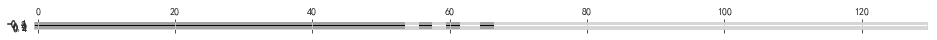

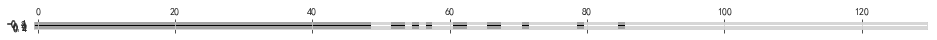

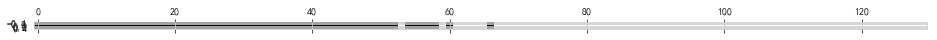

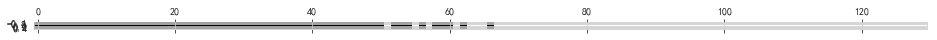

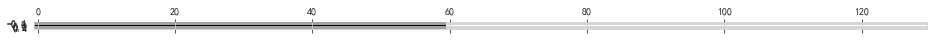

In [19]:
# 逐步特征重要性删减选择 
from sklearn.feature_selection import RFE
#根据a coef_ attribute or a feature_importances_ attribute
# 逐渐删除重要性最低的特征子集,直到特征达到指定需要个数为止
select_multi = RFE(RandomForestClassifier(n_estimators=500, random_state=42),
             n_features_to_select=60)
select1 = RFE(RandomForestClassifier(n_estimators=500, random_state=42),
             n_features_to_select=60)
select2 = RFE(RandomForestClassifier(n_estimators=500, random_state=42),
             n_features_to_select=60)
select3 = RFE(RandomForestClassifier(n_estimators=500, random_state=42),
             n_features_to_select=60)
select4 = RFE(RandomForestClassifier(n_estimators=500, random_state=42),
             n_features_to_select=60)
#select = RFE(LogisticRegression(penalty="l1"), n_features_to_select=40)
#n_features_to_select参数设置要选择的特征数目,默认选一半
select_multi.fit(ip_multiClassification_train_data_X, ip_multiClassification_train_data_Y)

select1.fit(ip_train_data_X_1, ip_train_data_Y_1)
select2.fit(ip_train_data_X_2, ip_train_data_Y_2)
select3.fit(ip_train_data_X_3, ip_train_data_Y_3)
select4.fit(ip_train_data_X_4, ip_train_data_Y_4)

# visualize the selected features:
mask_multi = select_multi.get_support() 
mask1 = select1.get_support()
mask2 = select2.get_support()
mask3 = select3.get_support()
mask4 = select4.get_support()
print(mask_multi)
print(mask1)
print(mask2)
print(mask3)
print(mask4)
plt.matshow(mask_multi.reshape(1, -1), cmap='gray_r')
plt.matshow(mask1.reshape(1, -1), cmap='gray_r')
plt.matshow(mask2.reshape(1, -1), cmap='gray_r')
plt.matshow(mask3.reshape(1, -1), cmap='gray_r')
plt.matshow(mask4.reshape(1, -1), cmap='gray_r')

ip_multiClassification_train_data_X = select_multi.transform(ip_multiClassification_train_data_X)
ip_multiClassification_test_data_X = select_multi.transform(ip_multiClassification_test_data_X)
ip_test_multiClassification_x = select_multi.transform(ip_test_multiClassification_x)

ip_train_data_X_1 = select1.transform(ip_train_data_X_1)
ip_test_data_X_1 = select1.transform(ip_test_data_X_1)
ip_test_x_1 = select1.transform(ip_test_x_1)

ip_train_data_X_2 = select2.transform(ip_train_data_X_2)
ip_test_data_X_2 = select2.transform(ip_test_data_X_2)
ip_test_x_2 = select1.transform(ip_test_x_2)

ip_train_data_X_3 = select3.transform(ip_train_data_X_3)
ip_test_data_X_3 = select3.transform(ip_test_data_X_3)
ip_test_x_3 = select1.transform(ip_test_x_3)

ip_train_data_X_4 = select4.transform(ip_train_data_X_4)
ip_test_data_X_4 = select4.transform(ip_test_data_X_4)
ip_test_x_4 = select1.transform(ip_test_x_4)



In [20]:
from sklearn.model_selection import KFold

# Some useful parameters which will come in handy later on
ntrain_multi = ip_multiClassification_train_data_X.shape[0]
ntest_multi = ip_multiClassification_test_data_X.shape[0]
print('ntrain_1: '+str(ntrain_multi) +'   '+ 'ntest_1: '+str(ntest_multi))

ntrain_1 = ip_train_data_X_1.shape[0]
ntest_1 = ip_test_data_X_1.shape[0]
print('ntrain_1: '+str(ntrain_1) +'   '+ 'ntest_1: '+str(ntest_1))

ntrain_2 = ip_train_data_X_2.shape[0]
ntest_2 = ip_test_data_X_2.shape[0]
print('ntrain_2: '+str(ntrain_2) +'   '+ 'ntest_2: '+str(ntest_2))

ntrain_3 = ip_train_data_X_3.shape[0]
ntest_3 = ip_test_data_X_3.shape[0]
print('ntrain_3: '+str(ntrain_3) +'   '+ 'ntest_3: '+str(ntest_3))

ntrain_4 = ip_train_data_X_4.shape[0]
ntest_4 = ip_test_data_X_4.shape[0]
print('ntrain_4: '+str(ntrain_4) +'   '+ 'ntest_4: '+str(ntest_4))

print(ip_train_data_X_1.shape,ip_test_data_X_1.shape)
print(ip_train_data_X_2.shape,ip_test_data_X_2.shape)
print(ip_train_data_X_3.shape,ip_test_data_X_3.shape)
print(ip_train_data_X_4.shape,ip_test_data_X_4.shape)



ntrain_1: 1040   ntest_1: 260
ntrain_1: 1040   ntest_1: 260
ntrain_2: 1040   ntest_2: 260
ntrain_3: 1040   ntest_3: 260
ntrain_4: 1040   ntest_4: 260
(1040, 60) (260, 60)
(1040, 60) (260, 60)
(1040, 60) (260, 60)
(1040, 60) (260, 60)


In [21]:

SEED = 0 
NFOLDS = 7
kf = KFold(n_splits = NFOLDS, random_state=SEED, shuffle=False)

def get_out_fold(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain_1,))
    oof_test = np.zeros((ntest_1,))
    oof_test_skf = np.empty((NFOLDS, ntest_1))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [22]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

rf = RandomForestClassifier(n_estimators=800, max_features='sqrt',max_depth=6,
                            min_samples_split=3, min_samples_leaf=2, n_jobs=1, verbose=0)

ada = AdaBoostClassifier(n_estimators=500, learning_rate=0.1)

et = ExtraTreesClassifier(n_estimators=500, n_jobs=1, max_depth=10, min_samples_leaf=2, verbose=0)

gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.008, min_samples_split=3, min_samples_leaf=2, max_depth=5, verbose=0)

dt = DecisionTreeClassifier(max_depth=8)

# knn = KNeighborsClassifier(n_neighbors = 5)
knn = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=5, p=2, 
                           weights='uniform')

svm = SVC(kernel='linear', C=0.025)

xgb = XGBClassifier(n_estimators=1000, max_depth= 6, min_child_weight= 3,gamma=0.9, subsample=0.8,
                  colsample_bytree=0.35, objective= 'binary:logistic', nthread=-1, scale_pos_weight=1)

cb = CatBoostClassifier(iterations=500,depth=4,learning_rate=0.09)

gnb = GaussianNB()

lr = LogisticRegression()

lda = LinearDiscriminantAnalysis()

qda = QuadraticDiscriminantAnalysis()
# ip_multiClassification_train_data_X,ip_multiClassification_test_data_X,
# ip_multiClassification_train_data_Y, ip_multiClassification_test_data_Y
x_train_multi = pd.DataFrame(ip_multiClassification_train_data_X).values 
x_test_multi = pd.DataFrame(ip_multiClassification_test_data_X).values 
y_train_multi = ip_multiClassification_train_data_Y.values
y_test_multi = ip_multiClassification_test_data_Y.values

x_train_1 = pd.DataFrame(ip_train_data_X_1).values 
x_test_1 = pd.DataFrame(ip_test_data_X_1).values 
y_train_1 = ip_train_data_Y_1.values
y_test_1 = ip_test_data_Y_1.values

x_train_2 = pd.DataFrame(ip_train_data_X_2).values 
x_test_2 = pd.DataFrame(ip_test_data_X_2).values 
y_train_2 = ip_train_data_Y_2.values
y_test_2 = ip_test_data_Y_2.values

x_train_3 = pd.DataFrame(ip_train_data_X_3).values 
x_test_3 = pd.DataFrame(ip_test_data_X_3).values 
y_train_3 = ip_train_data_Y_3.values
y_test_3 = ip_test_data_Y_3.values

x_train_4 = pd.DataFrame(ip_train_data_X_4).values 
x_test_4 = pd.DataFrame(ip_test_data_X_4).values 
y_train_4 = ip_train_data_Y_4.values
y_test_4 = ip_test_data_Y_4.values

print(x_train_1.shape,x_test_1.shape,y_train_1.shape,y_test_1.shape)
print(x_train_2.shape,x_test_2.shape,y_train_2.shape,y_test_2.shape)
print(x_train_3.shape,x_test_3.shape,y_train_3.shape,y_test_3.shape)
print(x_train_4.shape,x_test_4.shape,y_train_4.shape,y_test_4.shape)

(1040, 60) (260, 60) (1040,) (260,)
(1040, 60) (260, 60) (1040,) (260,)
(1040, 60) (260, 60) (1040,) (260,)
(1040, 60) (260, 60) (1040,) (260,)


In [23]:
print("Start")
print("-"*50 + "多分类：证型" + "-"*50)
rf_oof_train_multi, rf_oof_test_multi = get_out_fold(rf, x_train_multi, y_train_multi, x_test_multi) # Random Forest
ada_oof_train_multi, ada_oof_test_multi = get_out_fold(ada, x_train_multi, y_train_multi, x_test_multi) # AdaBoost
et_oof_train_multi, et_oof_test_multi = get_out_fold(et, x_train_multi, y_train_multi, x_test_multi) # Extra Trees
gb_oof_train_multi, gb_oof_test_multi = get_out_fold(gb, x_train_multi, y_train_multi, x_test_multi) # Gradient Boost
dt_oof_train_multi, dt_oof_test_multi = get_out_fold(dt, x_train_multi, y_train_multi, x_test_multi) # Decision Tree
knn_oof_train_multi, knn_oof_test_multi = get_out_fold(knn, x_train_multi, y_train_multi, x_test_multi) # KNeighbors
svm_oof_train_multi, svm_oof_test_multi = get_out_fold(svm, x_train_multi, y_train_multi, x_test_multi) # Support Vector machine
xgb_oof_train_multi, xgb_oof_test_multi = get_out_fold(xgb, x_train_multi, y_train_multi, x_test_multi) # XGBboost
gnb_oof_train_multi, gnb_oof_test_multi = get_out_fold(gnb, x_train_multi, y_train_multi, x_test_multi) # GaussianNB
cb_oof_train_multi, cb_oof_test_multi = get_out_fold(cb, x_train_multi, y_train_multi, x_test_multi) # CatBoost
lr_oof_train_multi, lr_oof_test_multi = get_out_fold(lr, x_train_multi, y_train_multi, x_test_multi) # LogisticRegression

x_train_multi = np.concatenate((rf_oof_train_multi, ada_oof_train_multi, et_oof_train_multi, dt_oof_train_multi,
                            knn_oof_train_multi, svm_oof_train_multi, xgb_oof_train_multi, gnb_oof_train_multi,cb_oof_train_multi), axis=1)
x_test_multi = np.concatenate((rf_oof_test_multi, ada_oof_test_multi, et_oof_test_multi, dt_oof_test_multi,
                           knn_oof_test_multi, svm_oof_test_multi, xgb_oof_test_multi, gnb_oof_test_multi,cb_oof_test_multi), axis=1)

Start
--------------------------------------------------多分类：证型--------------------------------------------------


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\prepro

0:	learn: 0.5587974	total: 94ms	remaining: 46.9s
1:	learn: 0.4366544	total: 114ms	remaining: 28.4s
2:	learn: 0.3689833	total: 133ms	remaining: 22.1s
3:	learn: 0.2809466	total: 152ms	remaining: 18.8s
4:	learn: 0.2362112	total: 172ms	remaining: 17.1s
5:	learn: 0.2124922	total: 194ms	remaining: 16s
6:	learn: 0.1865515	total: 214ms	remaining: 15.1s
7:	learn: 0.1685040	total: 234ms	remaining: 14.4s
8:	learn: 0.1485861	total: 250ms	remaining: 13.6s
9:	learn: 0.1278188	total: 266ms	remaining: 13.1s
10:	learn: 0.1089998	total: 282ms	remaining: 12.5s
11:	learn: 0.1010746	total: 300ms	remaining: 12.2s
12:	learn: 0.0931574	total: 319ms	remaining: 11.9s
13:	learn: 0.0886041	total: 338ms	remaining: 11.7s
14:	learn: 0.0862468	total: 359ms	remaining: 11.6s
15:	learn: 0.0832456	total: 376ms	remaining: 11.4s
16:	learn: 0.0816235	total: 396ms	remaining: 11.3s
17:	learn: 0.0800969	total: 417ms	remaining: 11.2s
18:	learn: 0.0747942	total: 435ms	remaining: 11s
19:	learn: 0.0712882	total: 452ms	remaining: 1

In [24]:
print("-"*50 + "西医诊断/支气管肺炎" + "-"*50)
rf_oof_train_1, rf_oof_test_1 = get_out_fold(rf, x_train_1, y_train_1, x_test_1) # Random Forest
ada_oof_train_1, ada_oof_test_1 = get_out_fold(ada, x_train_1, y_train_1, x_test_1) # AdaBoost
et_oof_train_1, et_oof_test_1 = get_out_fold(et, x_train_1, y_train_1, x_test_1) # Extra Trees
gb_oof_train_1, gb_oof_test_1 = get_out_fold(gb, x_train_1, y_train_1, x_test_1) # Gradient Boost
dt_oof_train_1, dt_oof_test_1 = get_out_fold(dt, x_train_1, y_train_1, x_test_1) # Decision Tree
knn_oof_train_1, knn_oof_test_1 = get_out_fold(knn, x_train_1, y_train_1, x_test_1) # KNeighbors
svm_oof_train_1, svm_oof_test_1 = get_out_fold(svm, x_train_1, y_train_1, x_test_1) # Support Vector machine
# xgb_oof_train_1, xgb_oof_test_1 = get_out_fold(xgb, x_train_1, y_train_1, x_test_1) # XGBboost
gnb_oof_train_1, gnb_oof_test_1 = get_out_fold(gnb, x_train_1, y_train_1, x_test_1) # GaussianNB
# cb_oof_train_1, cb_oof_test_1 = get_out_fold(cb, x_train_1, y_train_1, x_test_1) # CatBoost
lr_oof_train_1, lr_oof_test_1 = get_out_fold(lr, x_train_1, y_train_1, x_test_1) # LogisticRegression

x_train_1 = np.concatenate((rf_oof_train_1, ada_oof_train_1, et_oof_train_1, dt_oof_train_1,
                            knn_oof_train_1, svm_oof_train_1, gnb_oof_train_1), axis=1)
x_test_1 = np.concatenate((rf_oof_test_1, ada_oof_test_1, et_oof_test_1, dt_oof_test_1,
                           knn_oof_test_1, svm_oof_test_1, gnb_oof_test_1), axis=1)

print("-"*50 + "细菌性肺炎" + "-"*50)
rf_oof_train_2, rf_oof_test_2 = get_out_fold(rf, x_train_2, y_train_2, x_test_2) # Random Forest
ada_oof_train_2, ada_oof_test_2 = get_out_fold(ada, x_train_2, y_train_2, x_test_2) # AdaBoost
et_oof_train_2, et_oof_test_2 = get_out_fold(et, x_train_2, y_train_2, x_test_2) # Extra Trees
gb_oof_train_2, gb_oof_test_2 = get_out_fold(gb, x_train_2, y_train_2, x_test_2) # Gradient Boost
dt_oof_train_2, dt_oof_test_2 = get_out_fold(dt, x_train_2, y_train_2, x_test_2) # Decision Tree
knn_oof_train_2, knn_oof_test_2 = get_out_fold(knn, x_train_2, y_train_2, x_test_2) # KNeighbors
svm_oof_train_2, svm_oof_test_2 = get_out_fold(svm, x_train_2, y_train_2, x_test_2) # Support Vector machine
# xgb_oof_train_2, xgb_oof_test_2 = get_out_fold(xgb, x_train_2, y_train_2, x_test_2) # XGBboost
gnb_oof_train_2, gnb_oof_test_2 = get_out_fold(gnb, x_train_2, y_train_2, x_test_2) # GaussianNB
# cb_oof_train_2, cb_oof_test_2 = get_out_fold(cb, x_train_2, y_train_2, x_test_2) # CatBoost
lr_oof_train_2, lr_oof_test_2 = get_out_fold(lr, x_train_2, y_train_2, x_test_2) # LogisticRegression

x_train_2 = np.concatenate((rf_oof_train_2, ada_oof_train_2, et_oof_train_2, dt_oof_train_2,
                            knn_oof_train_2, svm_oof_train_2, gnb_oof_train_2), axis=1)
x_test_2 = np.concatenate((rf_oof_test_2, ada_oof_test_2, et_oof_test_2, dt_oof_test_2,
                           knn_oof_test_2, svm_oof_test_2, gnb_oof_test_2), axis=1)
print("-"*50 + "支原体肺炎" + "-"*50)
rf_oof_train_3, rf_oof_test_3 = get_out_fold(rf, x_train_3, y_train_3, x_test_3) # Random Forest
ada_oof_train_3, ada_oof_test_3 = get_out_fold(ada, x_train_3, y_train_3, x_test_3) # AdaBoost
et_oof_train_3, et_oof_test_3 = get_out_fold(et, x_train_3, y_train_3, x_test_3) # Extra Trees
gb_oof_train_3, gb_oof_test_3 = get_out_fold(gb, x_train_3, y_train_3, x_test_3) # Gradient Boost
dt_oof_train_3, dt_oof_test_3 = get_out_fold(dt, x_train_3, y_train_3, x_test_3) # Decision Tree
knn_oof_train_3, knn_oof_test_3 = get_out_fold(knn, x_train_3, y_train_3, x_test_3) # KNeighbors
svm_oof_train_3, svm_oof_test_3 = get_out_fold(svm, x_train_3, y_train_3, x_test_3) # Support Vector machine
# xgb_oof_train_3, xgb_oof_test_3 = get_out_fold(xgb, x_train_3, y_train_3, x_test_3) # XGBboost
gnb_oof_train_3, gnb_oof_test_3 = get_out_fold(gnb, x_train_3, y_train_3, x_test_3) # GaussianNB
# cb_oof_train_3, cb_oof_test_3 = get_out_fold(cb, x_train_3, y_train_3, x_test_3) # CatBoost
lr_oof_train_3, lr_oof_test_3 = get_out_fold(lr, x_train_3, y_train_3, x_test_3) # LogisticRegression

x_train_3 = np.concatenate((rf_oof_train_3, ada_oof_train_3, et_oof_train_3, dt_oof_train_3,
                            knn_oof_train_3, svm_oof_train_3, gnb_oof_train_3), axis=1)
x_test_3 = np.concatenate((rf_oof_test_3, ada_oof_test_3, et_oof_test_3, dt_oof_test_3,
                           knn_oof_test_3, svm_oof_test_3, gnb_oof_test_3), axis=1)

print("-"*50 + "病毒性肺炎" + "-"*50)
rf_oof_train_4, rf_oof_test_4 = get_out_fold(rf, x_train_4, y_train_4, x_test_4) # Random Forest
ada_oof_train_4, ada_oof_test_4 = get_out_fold(ada, x_train_4, y_train_4, x_test_4) # AdaBoost
et_oof_train_4, et_oof_test_4 = get_out_fold(et, x_train_4, y_train_4, x_test_4) # Extra Trees
gb_oof_train_4, gb_oof_test_4 = get_out_fold(gb, x_train_4, y_train_4, x_test_4) # Gradient Boost
dt_oof_train_4, dt_oof_test_4 = get_out_fold(dt, x_train_4, y_train_4, x_test_4) # Decision Tree
knn_oof_train_4, knn_oof_test_4 = get_out_fold(knn, x_train_4, y_train_4, x_test_4) # KNeighbors
svm_oof_train_4, svm_oof_test_4 = get_out_fold(svm, x_train_4, y_train_4, x_test_4) # Support Vector machine
# xgb_oof_train_4, xgb_oof_test_4 = get_out_fold(xgb, x_train_4, y_train_4, x_test_4) # XGBboost
gnb_oof_train_4, gnb_oof_test_4 = get_out_fold(gnb, x_train_4, y_train_4, x_test_4) # GaussianNB
# cb_oof_train_4, cb_oof_test_4 = get_out_fold(cb, x_train_4, y_train_4, x_test_4) # CatBoost
lr_oof_train_4, lr_oof_test_4 = get_out_fold(lr, x_train_4, y_train_4, x_test_4) # LogisticRegression

x_train_4 = np.concatenate((rf_oof_train_4, ada_oof_train_4, et_oof_train_4, dt_oof_train_4,
                            knn_oof_train_4, svm_oof_train_4,  gnb_oof_train_4), axis=1)
x_test_4 = np.concatenate((rf_oof_test_4, ada_oof_test_4, et_oof_test_4, dt_oof_test_4,
                           knn_oof_test_4, svm_oof_test_4, gnb_oof_test_4), axis=1)

print("Layer1 Finished")

--------------------------------------------------西医诊断/支气管肺炎--------------------------------------------------
--------------------------------------------------细菌性肺炎--------------------------------------------------
--------------------------------------------------支原体肺炎--------------------------------------------------
--------------------------------------------------病毒性肺炎--------------------------------------------------
Layer1 Finished


In [25]:
# #降维
# import numpy as np
# from sklearn.decomposition import PCA
# pca = PCA(n_components=4)
# x_train_1 = pca.fit_transform(x_train_1)
# x_train_2 = pca.fit_transform(x_train_2)
# x_train_3 = pca.fit_transform(x_train_3)
# x_train_4 = pca.fit_transform(x_train_4)

# ip_test_x_1 = pca.fit_transform(ip_test_x_1)
# ip_test_x_2 = pca.fit_transform(ip_test_x_2)
# ip_test_x_3 = pca.fit_transform(ip_test_x_3)
# ip_test_x_4 = pca.fit_transform(ip_test_x_4)

# # print ('降维后数据:')
# # print (x_train_1)


In [26]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier

# clf_multi = SVC(kernel="rbf",gamma="auto",degree=4).fit(x_train_multi, y_train_multi)
clf_multi = XGBClassifier(n_estimators=1000,max_depth=4,gamma=0.4,
                      colsample_bytree=1).fit(x_train_multi, y_train_multi)
clf_1 = SVC(kernel="rbf",gamma="auto",degree=4).fit(x_train_1, y_train_1)
clf_2 = XGBClassifier(n_estimators=1000,max_depth=6,gamma=0,
                      colsample_bytree=1).fit(x_train_2, y_train_2)
clf_3 = XGBClassifier(n_estimators=1000,max_depth=6,
                      colsample_bytree=0.45,min_child_weight= 3,
                     scale_pos_weight=1).fit(x_train_3, y_train_3)
clf_4 = SVC(kernel='linear', C=0.025).fit(x_train_4, y_train_4)

from sklearn.model_selection import cross_val_score
# ip_test_multiClassification_x = ip_test_multiClassification.drop(["证型"],axis=1)
# ip_test_multiClassification_y = ip_test_multiClassification["证型"]

scores_multi = cross_val_score(clf_multi,ip_multiClassification_test_data_X,ip_multiClassification_test_data_Y) 
print("多分类:证型 ",scores_multi.mean())

scores_1 = cross_val_score(clf_1,ip_test_x_1,ip_test_y_1) 
print("西医诊断/支气管肺炎: ",scores_1.mean())

scores_2 = cross_val_score(clf_2,ip_test_x_2,ip_test_y_2)  
print("细菌性肺炎: ",scores_2.mean())

scores_3 = cross_val_score(clf_3,ip_test_x_3,ip_test_y_3)  
print("支原体肺炎: ",scores_3.mean())

# print("ip_test_y_4: "+ip_test_y_4)
# scores_4 = cross_val_score(clf_4,
#                            ip_test_x_4,
#                            ip_test_y_4) 
# print("病毒性肺炎: ",scores_4.mean())



c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\prepro

多分类:证型  0.9805185021186572
西医诊断/支气管肺炎:  0.9748982360922659


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


细菌性肺炎:  0.8282828282828283
支原体肺炎:  0.880069350218604


c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


RandomForestClassifier


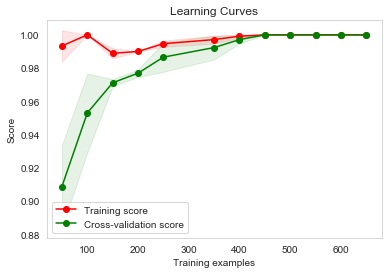

AdaBoostClassifier


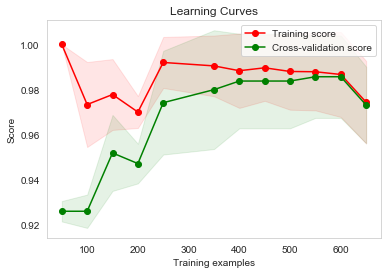

ExtraTreesClassifier


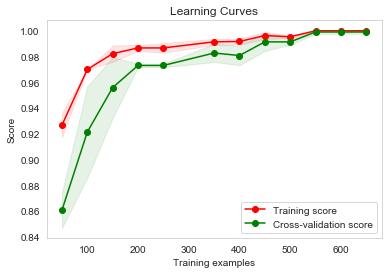

GradientBoostingClassifier


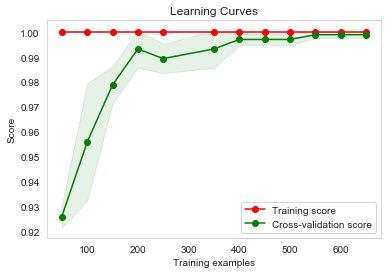

DecisionTreeClassifier


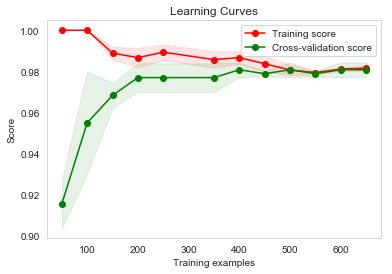

KNeighborsClassifier


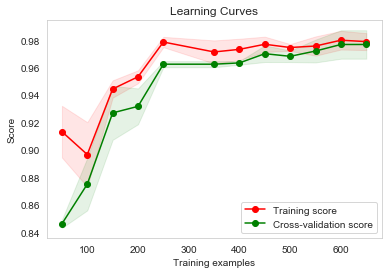

SVC


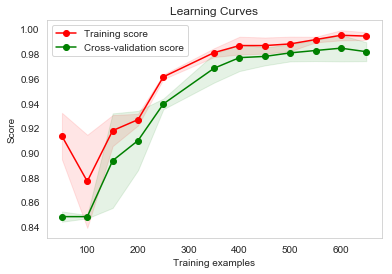

XGBClassifier


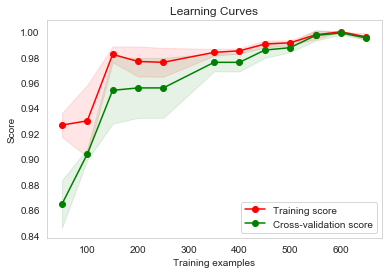

GaussianNB


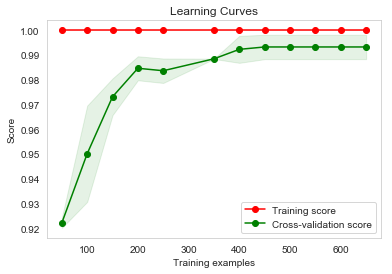

In [31]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), verbose=0):
    plt.style.use('dark_background')
    sns.set_style('whitegrid')
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X = x_train_multi
Y = y_train_multi


# RandomForest
rf_parameters = {'criterion':'gini','n_jobs': -1, 'n_estimators': 700 ,'max_features':'auto','warm_start': True,
                 'max_depth': 6,'min_samples_split':3,'random_state':1, 'min_samples_leaf': 2,'max_features' : 'sqrt','verbose': 0}

# AdaBoost
ada_parameters = {'n_estimators':500, 'learning_rate':0.1}

# ExtraTrees
et_parameters = {'n_jobs': -1, 'n_estimators':500, 'max_depth': 4, 'min_samples_leaf': 4, 'verbose': 0}

# GradientBoosting
gb_parameters = {'n_estimators': 500, 'max_depth': 7, 'min_samples_leaf': 2, 'verbose': 0}

# DecisionTree
dt_parameters = {'max_depth':3}

# KNeighbors
knn_parameters = {'n_neighbors':9,'algorithm':'auto','leaf_size':34}

# SVM
svm_parameters = {'kernel':'linear', 'C':0.025}

# XGB
gbm_parameters = {'n_estimators': 2000, 'max_depth': 6, 'min_child_weight': 3, 'gamma':0.9, 'subsample':0.8,
                  'colsample_bytree':0.25, 'objective': 'binary:logistic', 'nthread':-1, 'scale_pos_weight':1}

gnb_parameters = {}

cb_parameters = {}

title = "Learning Curves"

# 
print("RandomForestClassifier")
plot_learning_curve(RandomForestClassifier(**rf_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("AdaBoostClassifier")
plot_learning_curve(AdaBoostClassifier(**ada_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("ExtraTreesClassifier")
plot_learning_curve(ExtraTreesClassifier(**et_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("GradientBoostingClassifier")
plot_learning_curve(GradientBoostingClassifier(**gb_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("DecisionTreeClassifier")
plot_learning_curve(DecisionTreeClassifier(**dt_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("KNeighborsClassifier")
plot_learning_curve(KNeighborsClassifier(**knn_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("SVC")
plot_learning_curve(SVC(**svm_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("XGBClassifier")
plot_learning_curve(XGBClassifier(**gbm_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()
# 
print("GaussianNB")
plot_learning_curve(GaussianNB(**gnb_parameters), title, X, Y, cv=None,  n_jobs=4, 
                    train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
plt.show()

In [32]:
# print("CatBoost")
# plot_learning_curve(CatBoostClassifier(**cb_parameters), title, X, Y, cv=None,  n_jobs=4, 
#                     train_sizes=[50, 100, 150, 200, 250, 350, 400, 450, 500,550,600,650])
# plt.show()